In [1]:
import gzip
import random
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
import warnings
warnings.filterwarnings('ignore')

In [2]:
def readGz(path):
    for l in gzip.open(path, 'rt'):
        yield eval(l)

def readCSV(path):
    f = gzip.open(path, 'rt')
    f.readline()
    for l in f:
        yield l.strip().split(',')

In [3]:
example = readCSV("train_Interactions.csv.gz")
print(next(example))
del example

['u79354815', 'b14275065', '4']


# Question 1

In [4]:
### Would-read

train_size = 190000
val_size   = 10000

data = [line for line in readCSV("train_Interactions.csv.gz")]
train = data[:train_size]
val   = data[train_size:]
print(len(data))
print(len(train))
print(len(val))

200000
190000
10000


In [5]:
booksReadBy = defaultdict(set)
train_booksReadBy = defaultdict(set)
val_booksReadBy = defaultdict(set)
usersReadBook = defaultdict(set)
val_usersReadBook = defaultdict(set)
train_usersReadBook = defaultdict(set)
all_books = set()
val_all_books = set()
train_all_books = set()
    
for user, book, _ in data:
    all_books.add(book)
    usersReadBook[book].add(user)
    booksReadBy[user].add(book)

for user, book, _ in train:
    train_all_books.add(book)
    train_usersReadBook[book].add(user)
    train_booksReadBy[user].add(book)

for user, book, _ in val:
    val_all_books.add(book)
    val_usersReadBook[book].add(user)
    val_booksReadBy[user].add(book)

val_unread = []
all_books_count = len(all_books)
for user, book, _ in val: 
    unread_book = random.sample(all_books, 1)
    while(unread_book in list(booksReadBy[user])):
        unread_book = random.sample(all_books, 1)
    val_unread.append([user, str(unread_book[0]), '-1'])

val = val + val_unread
print(len(val))
print(val[0:3])

20000
[['u35176258', 'b30592470', '3'], ['u30851063', 'b81941226', '3'], ['u31368414', 'b40097012', '5']]


In [6]:
bookCount = defaultdict(int)
total_books_read = 0

for user, book, _ in train:
    bookCount[book]  += 1
    total_books_read += 1

mostPopular = [(bookCount[book], book) for book in bookCount]
mostPopular.sort()
mostPopular.reverse()

# Question 9

In [7]:
### Ratings Prediction
train_size = 190000
data       = [line for line in readCSV("train_Interactions.csv.gz")]
# random.shuffle(data)
train      = data[:train_size]
val        = data[train_size:]

allRatings = []
userBookRatings = defaultdict(lambda: defaultdict(float))
userRatings = defaultdict(list)
userBooks   = defaultdict(set)
bookUsers   = defaultdict(set)
all_users    = set()
all_books    = set()

for user, book, rating in train:
    all_users.add(user)
    all_books.add(book)
    rating = int(rating)
    allRatings.append(rating)
    userRatings[user].append(rating)
    userBookRatings[user][book] = rating
    userBooks[user].add(book)
    bookUsers[book].add(user)

globalAverage = sum(allRatings) / len(allRatings)
userAverage = {}
for user in userRatings:
    userAverage[user] = sum(userRatings[user]) / len(userRatings[user])

In [19]:
# Coordinate Descent
def coordinate_descent(lambda_opt = 1, threshold = 4 * 10**(-5), iterations = 20):

    alpha_sum, bu_sum, bb_sum = 0, 0, 0

    train_len = len(train)
    bu = defaultdict(lambda: 1)
    bb = defaultdict(lambda: 1)
    alpha = 0
    
    conv = 1; prev_MSE = 1
    #while(conv > threshold):
    for i in range(iterations):
        alpha_sum = 0
        for user, book, _ in train:
            alpha_sum += userBookRatings[user][book] - (bu[user] + bb[book])
        alpha = alpha_sum / train_len

        for user in userRatings:
            bu_sum = 0
            for book in userBooks[user]:
                bu_sum += userBookRatings[user][book] - (alpha + bb[book])
            bu[user] = bu_sum / (lambda_opt + len(userBooks[user]))

        for book in bookUsers:
            bb_sum = 0
            for user in bookUsers[book]:
                bb_sum += userBookRatings[user][book] - (alpha + bu[user])
            bb[book] = bb_sum / (lambda_opt + len(bookUsers[book]))

#         rating_labels = []
#         diff = 0
#         for user, book, rating in val:
#             user_rating = alpha + bu[user] + bb[book]
#             diff += (user_rating - int(rating)) ** 2

#         cur_MSE = diff / len(val)
#         conv = abs(cur_MSE / prev_MSE - 1)
#         prev_MSE = cur_MSE
        
    return alpha, bu, bb

In [20]:
# # Coordinate Descent
# lambda_opt = 1; threshold = 10**(-4)
    
# train_len = len(train)
# k = 1
# all_users_lst = list(all_users)
# all_books_lst = list(all_books)
# all_users_lst.sort()
# all_books_lst.sort()

# gamma_u = np.ones(len(all_users_lst)) * 0.5
# gamma_b = np.ones(len(all_books_lst)) * 0.5
# print(gamma_u)
# print(gamma_b)

# for i in range(2):
#     count_p = 0
#     count_n = 0
#     for user_ind, user in enumerate(all_users):
#         gamma_u_sum = 0
#         count = 0
#         for book_ind, book in enumerate(userBooks[user]):
#             count += 1
#             pred1 = alpha + bu[user] + bb[book]
#             pred2 = gamma_u[user_ind] * gamma_b[book_ind]
#             rating = userBookRatings[user][book]
#             temp = rating - (pred1 + pred2)
#             gamma_u_sum += gamma_b[book_ind] * temp
#         gamma_u_sum = gamma_u_sum / ((count) * lambda_opt)
#         gamma_u[user_ind] = gamma_u_sum
#     print(gamma_u)
#     for book_ind, book in enumerate(all_books):
#         gamma_b_sum = 0
#         count = 0
#         for user_ind, user in enumerate(bookUsers[book]):
#             count += 1
#             pred1 = alpha + bu[user] + bb[book]
#             pred2 = gamma_u[user_ind] * gamma_b[book_ind]
#             rating = userBookRatings[user][book]
#             temp = rating - (pred1 + pred2)
#             gamma_b_sum += gamma_u[user_ind] * temp
#         gamma_b_sum = gamma_b_sum / ((count) * lambda_opt)
#         gamma_b[book_ind] = gamma_b_sum
#     print(gamma_b)
        

In [21]:
# rating_labels = []
# diff = 0
# for user, book, rating in val:
#     if user in all_users_lst or book in all_users_lst: 
#         user_ind = all_users_lst.index(user)
#         book_ind = all_books_lst.index(book)
#         user_rating = alpha + bu[user] + bb[book] + gamma_u[user_ind] + gamma_b[book_ind]
#     else:
#         print('here')
#         user_rating = alpha + bu[user] + bb[book];
#     diff += (user_rating - int(rating)) ** 2

# MSE = diff / len(val)
# print('MSE on the validation set', MSE)

In [22]:
lambda_values = np.logspace(0, 1, num = 10)
# lambda_values = np.linspace(0, 10, num = 20)
print(lambda_values)

[ 1.          1.29154967  1.66810054  2.15443469  2.7825594   3.59381366
  4.64158883  5.9948425   7.74263683 10.        ]


In [23]:
MSEs = []
loop_count = 0
for lambda_opt in lambda_values:
    loop_count += 1; print(loop_count, end = ', ')
    alpha, bu, bb = coordinate_descent(lambda_opt, _, 20)
    rating_labels = []
    diff = 0
    for user, book, rating in val:
        user_rating = alpha + bu[user] + bb[book]
        diff += (user_rating - int(rating)) ** 2
    MSE = diff / len(val)
    MSEs.append(MSE)

1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 

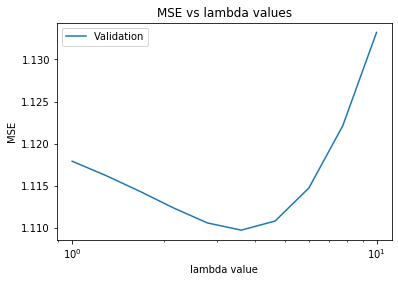

In [24]:
plt.plot(lambda_values, MSEs, label='Validation')
plt.ylabel('MSE')
plt.xlabel('lambda value'), plt.xscale('log')
plt.title('MSE vs lambda values')
plt.legend()
plt.show()

In [33]:
indx = MSEs.index(min(MSEs))
print('Lambda which has lowest MSE is:', lambda_values[indx])
print('This lambda value has MSE:     ', MSEs[indx])

Lambda which has lowest MSE is: 3.5938136638046276
This lambda value has MSE:      1.1096943083546775


In [36]:
alpha, bu, bb = coordinate_descent(2.8, 100)

In [37]:
with open("predictions_Rating.txt", 'w') as predictions:
    for l in open("pairs_Rating.txt"):
        if l.startswith("userID"):
            #header
            predictions.write(l)
            continue
        user, book = l.strip().split('-')
        user_rating = alpha + bu[user] + bb[book]
        predictions.write(user + '-' + book + ',' + str(user_rating) + '\n')

In [ ]:
def feature(datum, func1, func2, func3):
    user, book, _ = datum
    feat = [1]
    jac_sims = func1(user, book)
    if len(jac_sims) == 0: jac_val = 0
    else: jac_val = max(jac_sims)
    feat.append(jac_val)
    pop_val = book in return1
    feat.append(pop_val)